In [1]:
import win32com.client as com
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
## Connecting the COM Server => Open a new Vissim Window:
Vissim = com.Dispatch("Vissim.Vissim")


In [3]:
# Loads the VISSIM file and opens it
# Locat path where the file is
Vissim.LoadNet(r'C:\Users\chase\Documents\vissimpark\SLU_example\\SLU-fnl-baseline.inpx')
Vissim.LoadLayout(r'C:\Users\chase\Documents\vissimpark\SLU_example\\SLU-fnl-baseline.layx' )

com_error: (-2147352567, 'Exception occurred.', (0, 'VISSIM.Vissim.2100', 'The layout file does not exist.', None, 0, -2147352567), None)

In [4]:
# Delete all previous simulation runs first:
for simRun in Vissim.Net.SimulationRuns:
    Vissim.Net.SimulationRuns.RemoveSimulationRun(simRun)

In [5]:
for cnt_Sim in range(1):
    Vissim.Simulation.SetAttValue('RandSeed', cnt_Sim + 1) # Note: RandSeed 0 is not allowed
    Vissim.Simulation.RunContinuous()

Vissim.ResumeUpdateGUI(True); # allow updating of the complete Vissim workspace (network editor, list, chart and signal time table windows)
Vissim.Graphics.CurrentNetworkWindow.SetAttValue("QuickMode",1) # activate QuickMode

KeyboardInterrupt: 

In [6]:
# List of all Simulation runs:
Attributes      = ['Timestamp', 'RandSeed', 'SimEnd']
number_of_runs  = Vissim.Net.SimulationRuns.Count
List_Sim_Runs   = Vissim.Net.SimulationRuns.GetMultipleAttributes(Attributes)
for cnt_S in range(number_of_runs):
    print( '%s | %d | %d ' % (List_Sim_Runs[cnt_S][0], List_Sim_Runs[cnt_S][1], List_Sim_Runs[cnt_S][2]))


2021-08-04 00:26:32 | 1 | 10800 
2021-08-04 01:39:59 | 2 | 10800 
2021-08-04 02:47:32 | 3 | 10800 
2021-08-04 03:52:53 | 4 | 10800 
2021-08-04 04:58:43 | 5 | 10800 
2021-08-04 06:08:13 | 6 | 10800 
2021-08-04 07:13:05 | 7 | 10800 
2021-08-04 08:17:23 | 8 | 10800 
2021-08-04 09:21:12 | 9 | 10800 
2021-08-04 10:24:21 | 10 | 10800 
2021-08-04 11:27:36 | 11 | 10800 
2021-08-04 12:30:16 | 12 | 10800 
2021-08-04 13:32:35 | 13 | 10800 
2021-08-04 14:35:41 | 14 | 10800 
2021-08-04 15:40:33 | 15 | 10800 
2021-08-04 16:43:47 | 16 | 5528 


In [9]:
# data collection measurement grouping is fuckin horseshit

## ========================================================================
# Results of Simulations:
#==========================================================================
# from data collection points
No_Veh = []
Speed = []
Acceleration = []
Occupancy = []
dc=[]
time=[]
sim_run_list=[]
# Data Collection
num_dp = 4
dc_measurements = [25,26,27,28,29,30,31,32] # one lane measurements (3 per blockface)
dc_measurements = [1,2,3,33,34,35,36,37,38,39,40,41] # two lanes measurements

for DC_measurement_number in dc_measurements:

    DC_measurement = Vissim.Net.DataCollectionMeasurements.ItemByKey(DC_measurement_number)
# Syntax to get the data:
#   DC_measurement.AttValue('Vehs(sub_attribut_1, sub_attribut_2, sub_attribut_3)')
#
# sub_attribut_1: SimulationRun (same as described at Vehicle Travel Time Measurements)
# sub_attribut_2: TimeInterval  (same as described at Vehicle Travel Time Measurements)
# sub_attribut_3: VehicleClass  (same as described at Vehicle Travel Time Measurements)
#
# The value of on time interval is the arithmetic mean of all single values of the vehicles.

# Example #1:
# Average value of all simulations (1. input = Avg)
# 	of the 1st time interval (2. input = 1)
#   of all vehicle classes (3. input = All)
    for sim_run in range(1,14):
        for time_int in range(1,166):
            vehicle_str = 'Vehs        ('+str(sim_run) +','+ str(time_int) + ',All)'
            speed_str = 'Speed        ('+str(sim_run) +','+ str(time_int) + ',All)'
            
            #print(speed_str)
            sim_run_list.append(sim_run)
            dc.append(DC_measurement_number)
            time.append(time_int)
            No_Veh.append(DC_measurement.AttValue(vehicle_str)) # number of vehicles
            Speed.append(DC_measurement.AttValue(speed_str)) # Speed of vehicles

            
df = pd.DataFrame(list(zip(time, dc, sim_run_list, No_Veh, Speed )),
               columns =['Time', 'Data_Measurement','Sim_Run', 'No_Veh', 'Speed'])


In [10]:
df

,Time,Data_Measurement,Sim_Run,No_Veh,Speed
0,1,1,1,8,23.893990
1,2,1,1,5,18.973178
2,3,1,1,6,19.367767
3,4,1,1,3,28.182006
4,5,1,1,5,23.686309
...,...,...,...,...,...
25735,161,41,13,4,21.009123
25736,162,41,13,1,21.212228
25737,163,41,13,5,18.244228
25738,164,41,13,9,20.178368


In [23]:
import matplotlib.pyplot as plt
import numpy as np

In [27]:
single_df = df.loc[df['Data_Measurement'] == 2]

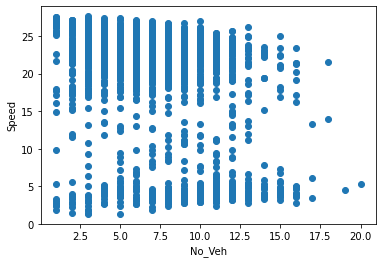

In [28]:
plt.scatter(single_df["No_Veh"].values, single_df["Speed"].values)
plt.xlabel("No_Veh")
plt.ylabel("Speed")
plt.show()

In [29]:
speed_means = {}
for pair in zip(list(single_df["No_Veh"].values), list(single_df["Speed"].values)):
    if pair[0] not in speed_means:
        speed_means[pair[0]] = [pair[1]]
    else:
        speed_means[pair[0]].append(pair[1])
        
for item in speed_means:
    speed_means[item] = np.mean(speed_means[item])

In [30]:
num_veh = []
mean_speed = []
for item in speed_means:
    num_veh.append(item)
    mean_speed.append(item)

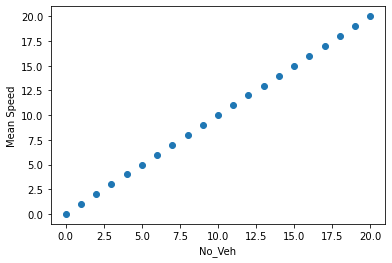

In [31]:
plt.scatter(num_veh, mean_speed)
plt.xlabel("No_Veh")
plt.ylabel("Mean Speed")
plt.show()

In [ ]:
df.to_csv('Parking5.csv', index=False)

In [17]:
## ========================================================================
# Saving
#==========================================================================
Vissim.SaveNetAs(r'C:\Users\sgunes\Documents\\DOE PNNL Curbspace project\\VISSIM\\Scenario1 - Copy\\VISSIM\\SLU-fnl-baseline.inpx')
Vissim.SaveLayoutr'C:\Users\sgunes\Documents\\DOE PNNL Curbspace project\\VISSIM\\Scenario1 - Copy\\VISSIM\\SLU-fnl-baseline.layx'')

## ========================================================================
# End Vissim
#==========================================================================
Vissim = None
